In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# define some helper functions first

In [ ]:
def remove_outliers(series,percentile):
    lower_bound = series.quantile(percentile)
    upper_bound = series.quantile(1-percentile)

    return series[(series > lower_bound) & (series < upper_bound)]

def get_accuracies(ground_truth, prediction_value, c):
                   
    ground_truth = 1*ground_truth # change bools to numbers
    prediction = 1*(prediction_value <= c)

    # count false positives
    fp = np.sum((ground_truth == 0) & (prediction == 1))

    # find false negatives
    fn = np.sum((ground_truth == 1) & (prediction == 0))

    # find true positives
    tp = np.sum((ground_truth == 1) & (prediction == 1))

    # find true negatives
    tn = np.sum((ground_truth == 0) & (prediction == 0))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return precision, recall, tp, tn, fp, fn

def get_AUC(ground_truth, prediction_value,min_prediction_score,max_prediction_score,plot=False): # higher = less synthesizable
    
    tp_list = []
    tn_list = []
    fp_list = []
    fn_list = []

    cutoffs = np.linspace(min_prediction_score,max_prediction_score,100)

    for c in cutoffs:
    
        precision, recall, tp, tn, fp, fn = get_accuracies(ground_truth, prediction_value, c)

        tp_list += [tp]
        tn_list += [tn]
        fp_list += [fp]
        fn_list += [fn]

    tp = np.array(tp_list)
    tn = np.array(tn_list)
    fp = np.array(fp_list)
    fn = np.array(fn_list)
        
    TPR = tp/(tp+fn)
    FPR = fp/(fp+tn)

    AUC = np.abs(np.trapz(TPR,FPR))
    
    if plot==True:
        plt.scatter(FPR,TPR)
        plt.show()

    return AUC

# read in data

In [15]:
data = pd.read_csv('../Computing Emin for QM9/data/clean/qm9.csv',usecols=['smiles_1 sa_score','Emin','Reported'])

ground_truth = data['Reported']
data = data[data['smiles_1 sa_score'] != 'ERROR']

data['smiles_1 sa_score'] = data['smiles_1 sa_score'].astype(float)

prediction = data['smiles_1 sa_score']


sa_score_min = prediction.min()
sa_score_max = prediction.max()

# plot Emin AUC for all misclassified datapoints at varying SA Score cutoffs

In [16]:
sa_score_cutoffs = [prediction.quantile(p) for p in np.linspace(0.1,0.9,30)]
n_misclassified = []
Emin_AUC_list = []


for cutoff in tqdm(sa_score_cutoffs):
    incorrect_reported = data.query(f'Reported == True & `smiles_1 sa_score` >= {cutoff}') # actually reported but SA score says unsynthesizable
    incorrect_unreported = data.query(f'Reported == False & `smiles_1 sa_score` < {cutoff}') # actually unreported but SA score says synthesizable
    incorrect = pd.concat([incorrect_reported,incorrect_unreported])
    
    n_misclassified += [len(incorrect)]
    Emin_AUC_list += [get_AUC(incorrect['Reported'], incorrect['Emin'],0,2)]
#     print(f'There are {len(incorrect_reported) + len(incorrect_unreported)} molecules which SA score predicts incorrect synthesizabilities.')
#     print(f'{len(incorrect_reported)} are actually reported')
#     print(f'{len(incorrect_unreported)} are actually unreported')
#     print(f"SA Score AUC for incorrectly predicted compounds is {get_AUC(incorrect['Reported'], incorrect['smiles_1 sa_score'],1,10)}")
#     print(f"Emin AUC for incorrectly predicted compounds is {get_AUC(incorrect['Reported'], incorrect['Emin'],0,2)}")

100%|██████████| 30/30 [00:07<00:00,  3.82it/s]


Text(0.5, 0, 'SA Score Cutoff (< cutoff = synthesizable)')

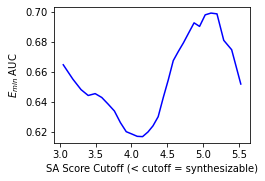

In [17]:
plt.figure(figsize=(3.5,2.5))

plt.plot(sa_score_cutoffs,Emin_AUC_list,color='blue',label=r'$E_{min}$ AUC')
plt.ylabel(r'$E_{min}$ AUC')
plt.xlabel('SA Score Cutoff (< cutoff = synthesizable)')

# plot Emin distributions when SA Score cutoff = recall of 0.5

([], [])

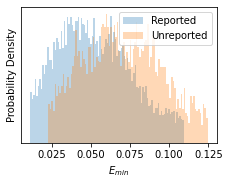

In [18]:
percentile = 0.5
sa_score_reported_median = data.query('Reported == True')['smiles_1 sa_score'].quantile(percentile)

incorrect_reported = data.query(f'Reported == True & `smiles_1 sa_score` >= {sa_score_reported_median}') # actually reported but SA score says unsynthesizable
incorrect_unreported = data.query(f'Reported == False & `smiles_1 sa_score` < {sa_score_reported_median}') # actually unreported but SA score says synthesizable

plt.figure(figsize=(3.5,2.5))
plt.hist(remove_outliers(incorrect_reported['Emin'],0.05),label='Reported',bins=100,density=True,alpha=0.3)
plt.hist(remove_outliers(incorrect_unreported['Emin'],0.05),label='Unreported',bins=100,density=True,alpha=0.3)
plt.legend(loc='best')
plt.xlabel(r'$E_{min}$')
plt.ylabel('Probability Density')
plt.yticks([])

# plot Emin distributions when SA Score cutoff = recall of 0.5

([], [])

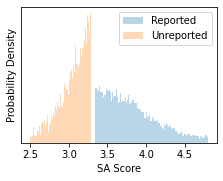

In [19]:
plt.figure(figsize=(3.5,2.5))
plt.hist(remove_outliers(incorrect_reported['smiles_1 sa_score'],0.05),label='Reported',bins=100,density=True,alpha=0.3)
plt.hist(remove_outliers(incorrect_unreported['smiles_1 sa_score'],0.05),label='Unreported',bins=100,density=True,alpha=0.3)
plt.legend()
plt.xlabel('SA Score')
plt.ylabel('Probability Density')
plt.yticks([])